# 数据集 Class

In [1]:
import os   
import copy
import math
import argparse
import time
from datetime import datetime

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from PIL import Image

def label(filename):
    if   'Cr'  in filename:  return 0
    elif 'In'  in filename:  return 1
    elif 'Pa'  in filename:  return 2
    elif 'PS'  in filename:  return 3   
    elif 'RS'  in filename:  return 4   
    elif 'Sc'  in filename:  return 5  
    
class Dataset_NEU_CLS(torch.utils.data.Dataset):
    def __init__(self):
        self.root_dir = '/data1/workspace_02/Data/NEU_CLS'
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.file_list = os.listdir(self.root_dir)
        self.x = torch.stack([self.transform(Image.open(os.path.join(self.root_dir, self.file_list[i]))) for i in range(len(self.file_list))])
        self.y = torch.stack([torch.tensor(label(os.path.join(self.root_dir, self.file_list[i]))) for i in range(len(self.file_list))])
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
dataset = Dataset_NEU_CLS()

# 迪利克雷分布进行数据分组

In [2]:
argparser = argparse.ArgumentParser()
args = argparser.parse_args(args=[])

args.num_clients = 5
args.degree_noniid = 100 # 数值越大，越接近独立同分布
args.batch_size = 64    


def generate_index_of_each_clients(args, dataset):
    
    labels = np.array(dataset.y)                                                           #;print(labels.shape)
    num_classes = len(np.unique(labels))                                                         #;print(num_classes)
    
    # 每一类样本在每个用户上的分配比例
    np.random.seed(123)
    label_distribution = np.random.dirichlet([args.degree_noniid] * args.num_clients, num_classes)       
    #print('【label_distribution】:a np array with shape',label_distribution.shape, '\n\n', label_distribution)

    # 每类样本的数据索引
    index_of_each_class = [np.argwhere(labels == y).flatten() for y in range(num_classes)]        
    #print('\n【index_of_each_class】: a list with 10 list elements: \n') 
    for class_ in range(num_classes):
        #print('data idx list of class ', class_, ': a list with (', len(index_of_each_class[class_]), ') elements')
        pass
    
    # 每个用户的数据索引
    index_of_each_clients = [[] for _ in range(args.num_clients)]           
    for c, fracs in zip(index_of_each_class, label_distribution):
        for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1] * len(c)).astype(int))):
            index_of_each_clients[i] += [idcs]
    index_of_each_clients = [set(np.concatenate(idcs)) for idcs in index_of_each_clients]  
    print('\n【index_of_each_clients】: a list with 5 set elements: \n')
    for client in range(args.num_clients):
        print('data idx list of client ', client, ': a set with (', len(index_of_each_clients[client]), ') elements')
        pass
    return index_of_each_clients

index_of_each_clients = generate_index_of_each_clients(args, dataset)


【index_of_each_clients】: a list with 5 set elements: 

data idx list of client  0 : a set with ( 338 ) elements
data idx list of client  1 : a set with ( 370 ) elements
data idx list of client  2 : a set with ( 341 ) elements
data idx list of client  3 : a set with ( 392 ) elements
data idx list of client  4 : a set with ( 359 ) elements


In [3]:
class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)
    def __len__(self):
        return len(self.idxs)
    def __getitem__(self, item):
        data, target = self.dataset[int(self.idxs[item])]
        return data, target
    

train_loaders = {};  test_loaders = {}
for client in range(args.num_clients):
    train_loaders[client] = torch.utils.data.DataLoader(DatasetSplit(dataset, list(index_of_each_clients[client])[0:int(0.8*len(index_of_each_clients[client]))]), batch_size=args.batch_size, shuffle=True, drop_last=True)#;print(len(train_loaders[client]))
    test_loaders[client]  = torch.utils.data.DataLoader(DatasetSplit(dataset, list(index_of_each_clients[client])[int(0.8*len(index_of_each_clients[client])):]),  batch_size=args.batch_size, shuffle=True, drop_last=True)#;print(len(test_loaders[client]))

# 查看数据

In [12]:
#数据量 
for client in range(5):
    print(len(train_loaders[client].dataset.idxs))

270
296
272
313
287


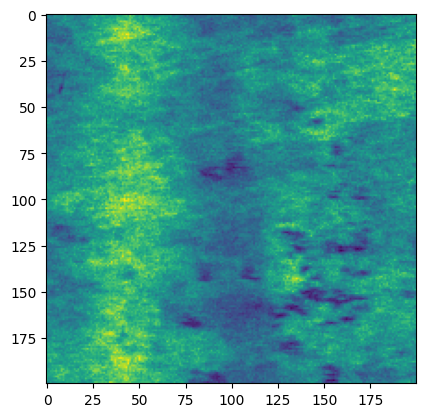

In [22]:
# 可视化
import matplotlib.pyplot as plt
for x,y in train_loaders[0]:
    plt.imshow(x[0][0])
    break